# Deep CNN Architectures

We experiment with deeper convolutional networks in convnet1.py, convnet2.py and convnet3.py.
* convnet1.py - DeepConvNet(object)  
  {conv-relu-maxpool} x (L) - affine-relu-affine-softmax  
* convnet2.py - DeepConvNet2(object)  
  {{conv-relu}x(L)-max pool}x(B)-affine-relu-affine-softmax  
* convnet3.py - DeepConvNet3(object)  
  {{conv-(bn)-relu}x(L)-max pool}x(B)-{affine-(bn)-relu-(DO)}-affine-softmax  

Due to the long training time required to characterize these deeper CNNs, we use two notebooks so that we can parallel the developing and prototyping of networks and the training of these networks for more than 5 epochs:  

DeepCNN-Prototyping.ipynb - used to develop and prototype the Deep CNNs  
DeepCNN-Training.ipynb - used to train the Deep CNNs for 10 epochs or more 

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver
from cs231n.classifiers.convnet2 import *
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape


X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


## Train Deep CNN Architecture 1

A multi-layer convolutional network with an arbitrary number of CONV layers with the following architecture:  
  
     {conv-relu-maxpool} x (L) - affine-relu-affine-softmax  

We discovered that this architecture works best when L < 3. 

'CONV1=32x3x3 CONV2=128x3x3':([32,128],[3,3])  
(Epoch 8 / 8) train acc: 0.985000; val_acc: 0.743000  

'CONV1=64x3x3 CONV2=128x3x3':([64,128],[3,3])  
(Epoch 8 / 8) train acc: 0.989000; val_acc: 0.737000  

There is an overfitting problem. Training accuracy --> 100%, but validation accurancy cannot break past 75%  

In [29]:
from cs231n.classifiers.convnet1 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'CONV1=32x3x3 CONV2=128x3x3':([32,128],[3,3]),
                          'CONV1=64x3x3 CONV2=128x3x3':([64,128],[3,3])  
                        }
learning_rates = [3e-4]
regularization_strengths = [0.001]

for label, network in network_architectures.iteritems():
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                model = DeepConvNet(num_filters=n, filter_sizes=f, weight_scale=1e-2, hidden_dim=500, reg=reg, verbose=False)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=8, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },lr_decay=0.95, 
                    verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: CONV1=64x3x3 CONV2=128x3x3
Run number: 0 
Learning rate: 3.000000e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 7840) loss: 2.518515
(Epoch 0 / 8) train acc: 0.142000; val_acc: 0.167000
(Iteration 21 / 7840) loss: 2.042790
(Iteration 41 / 7840) loss: 1.912951
(Iteration 61 / 7840) loss: 2.165797
(Iteration 81 / 7840) loss: 1.842493
(Iteration 101 / 7840) loss: 1.904907
(Iteration 121 / 7840) loss: 1.618373
(Iteration 141 / 7840) loss: 1.601550
(Iteration 161 / 7840) loss: 1.388225
(Iteration 181 / 7840) loss: 1.352792
(Iteration 201 / 7840) loss: 1.256573
(Iteration 221 / 7840) loss: 1.361286
(Iteration 241 / 7840) loss: 1.369861
(Iteration 261 / 7840) loss: 1.186020
(Iteration 281 / 7840) loss: 1.442590
(Iteration 301 / 7840) loss: 1.385815
(Iteration 321 / 7840) loss: 1.614393
(Iteration 341 / 7840) loss: 1.348813
(Iteration 361 / 7840) loss: 1.423826
(Iteration 381 / 7840) loss: 1.295474
(Iteration 401 / 7840) loss: 1.396899
(Iteration 421 / 7840) loss: 1.443517
(Iter

CONV1=32x3x3 CONV2=128x3x3 (Version 1) lr = 3.000000e-04; reg = 1.000000e-03, val accuracy: 0.744000
CONV1=64x3x3 CONV2=128x3x3 (Version 1) lr = 3.000000e-04; reg = 1.000000e-03, val accuracy: 0.743000
best validation accuracy achieved during cross-validation: 0.744000



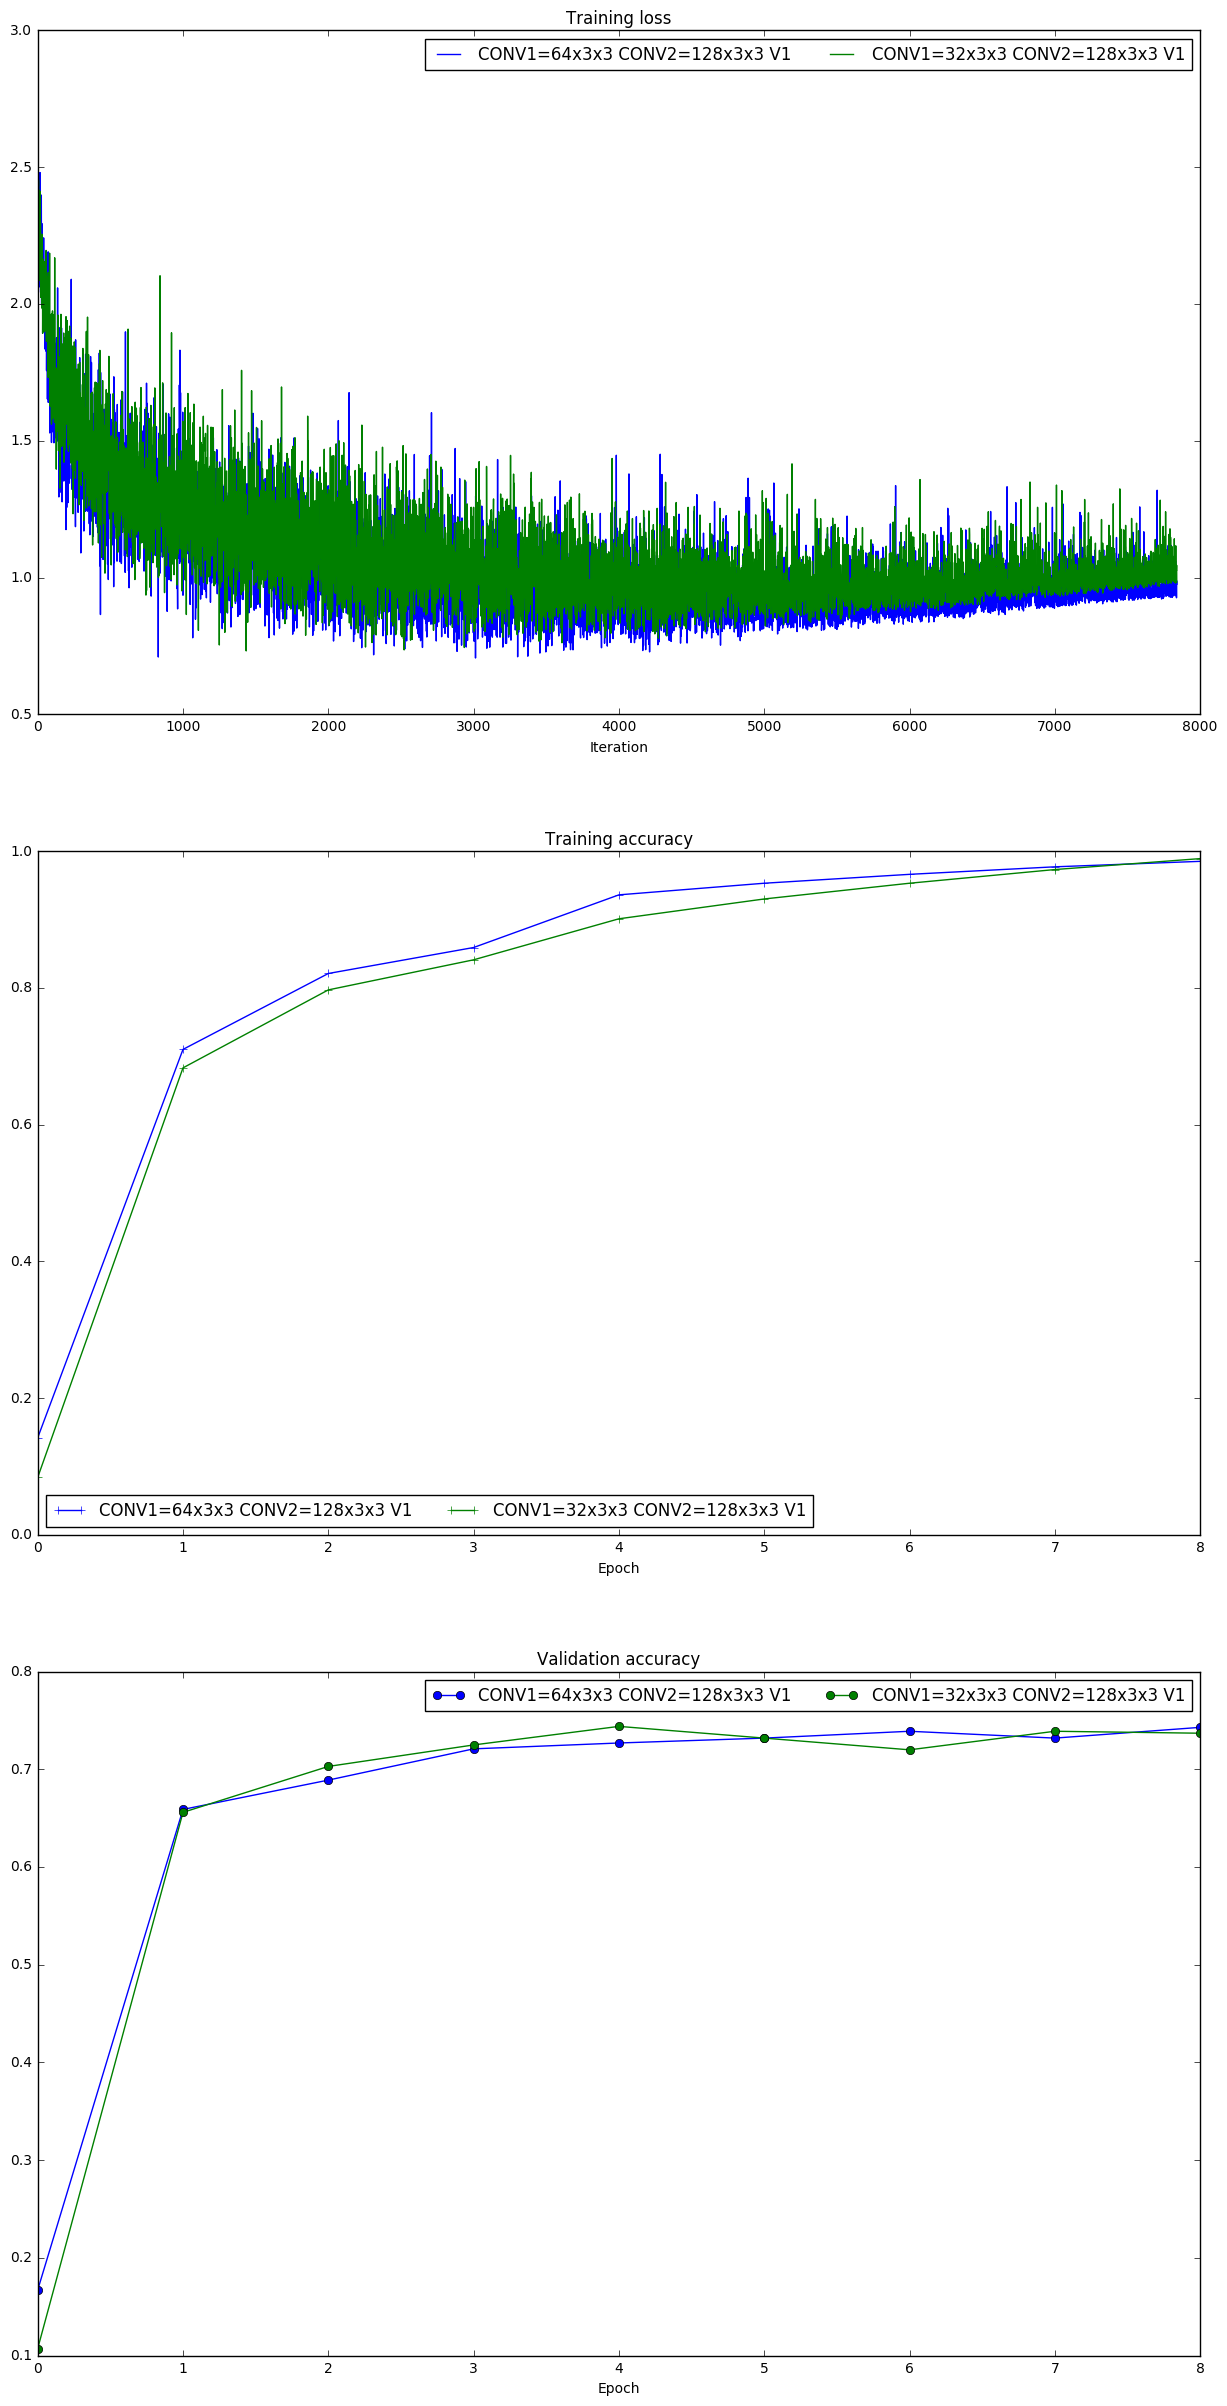

In [30]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

In [28]:
print solvers

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

{('CONV1=64x3x3 CONV2=128x3x3', 0, 1, 0.0003, 0.001): <cs231n.solver.Solver object at 0x0000000002B69E80>, ('CONV1=32x3x3 CONV2=128x3x3', 0, 1, 0.0003, 0.001): <cs231n.solver.Solver object at 0x0000000008F89EB8>}
Validation set accuracy:  0.728
Test set accuracy:  0.717


## Deep CNN Architecture 2

A multi-layer convolutional network with an arbitrary number of CONV layers with the following architecture: {(conv - relu} x (L) - max pool} x (B) - {affine - relu - affine - softmax}

L = B = 2
Maximize number of filters in CONV layers

In [4]:
from cs231n.classifiers.convnet2 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {
                        'CONV128-CONV128-Pool-CONV256-CONV256-Pool':([[128,128],[256,256]],[[3,3],[3,3]]),
                        }
learning_rates = [3e-4 ,5e-04]
regularization_strengths = [0.001]

for label, network in network_architectures.iteritems():
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet2(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=3, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: CONV128-CONV128-Pool-CONV256-CONV256-Pool
Run number: 0 
Learning rate: 3.000000e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 2940) loss: 2.762009
(Epoch 0 / 3) train acc: 0.087000; val_acc: 0.098000
(Iteration 21 / 2940) loss: 2.387563
(Iteration 41 / 2940) loss: 2.180379
(Iteration 61 / 2940) loss: 1.974261
(Iteration 81 / 2940) loss: 1.818250
(Iteration 101 / 2940) loss: 1.874447
(Iteration 121 / 2940) loss: 1.801186
(Iteration 141 / 2940) loss: 1.677286
(Iteration 161 / 2940) loss: 1.476672
(Iteration 181 / 2940) loss: 1.659024
(Iteration 201 / 2940) loss: 1.697277
(Iteration 221 / 2940) loss: 1.870449
(Iteration 241 / 2940) loss: 1.674628
(Iteration 261 / 2940) loss: 1.322073
(Iteration 281 / 2940) loss: 1.444809
(Iteration 301 / 2940) loss: 1.622731
(Iteration 321 / 2940) loss: 1.118565
(Iteration 341 / 2940) loss: 1.425377
(Iteration 361 / 2940) loss: 1.389453
(Iteration 381 / 2940) loss: 1.432738
(Iteration 401 / 2940) loss: 1.291262
(Iteration 421 / 2940) loss:

CONV128-CONV128-Pool-CONV256-CONV256-Pool (Version 1) lr = 3.000000e-04; reg = 1.000000e-03, val accuracy: 0.754000
CONV128-CONV128-Pool-CONV256-CONV256-Pool (Version 2) lr = 5.000000e-04; reg = 1.000000e-03, val accuracy: 0.745000
best validation accuracy achieved during cross-validation: 0.754000



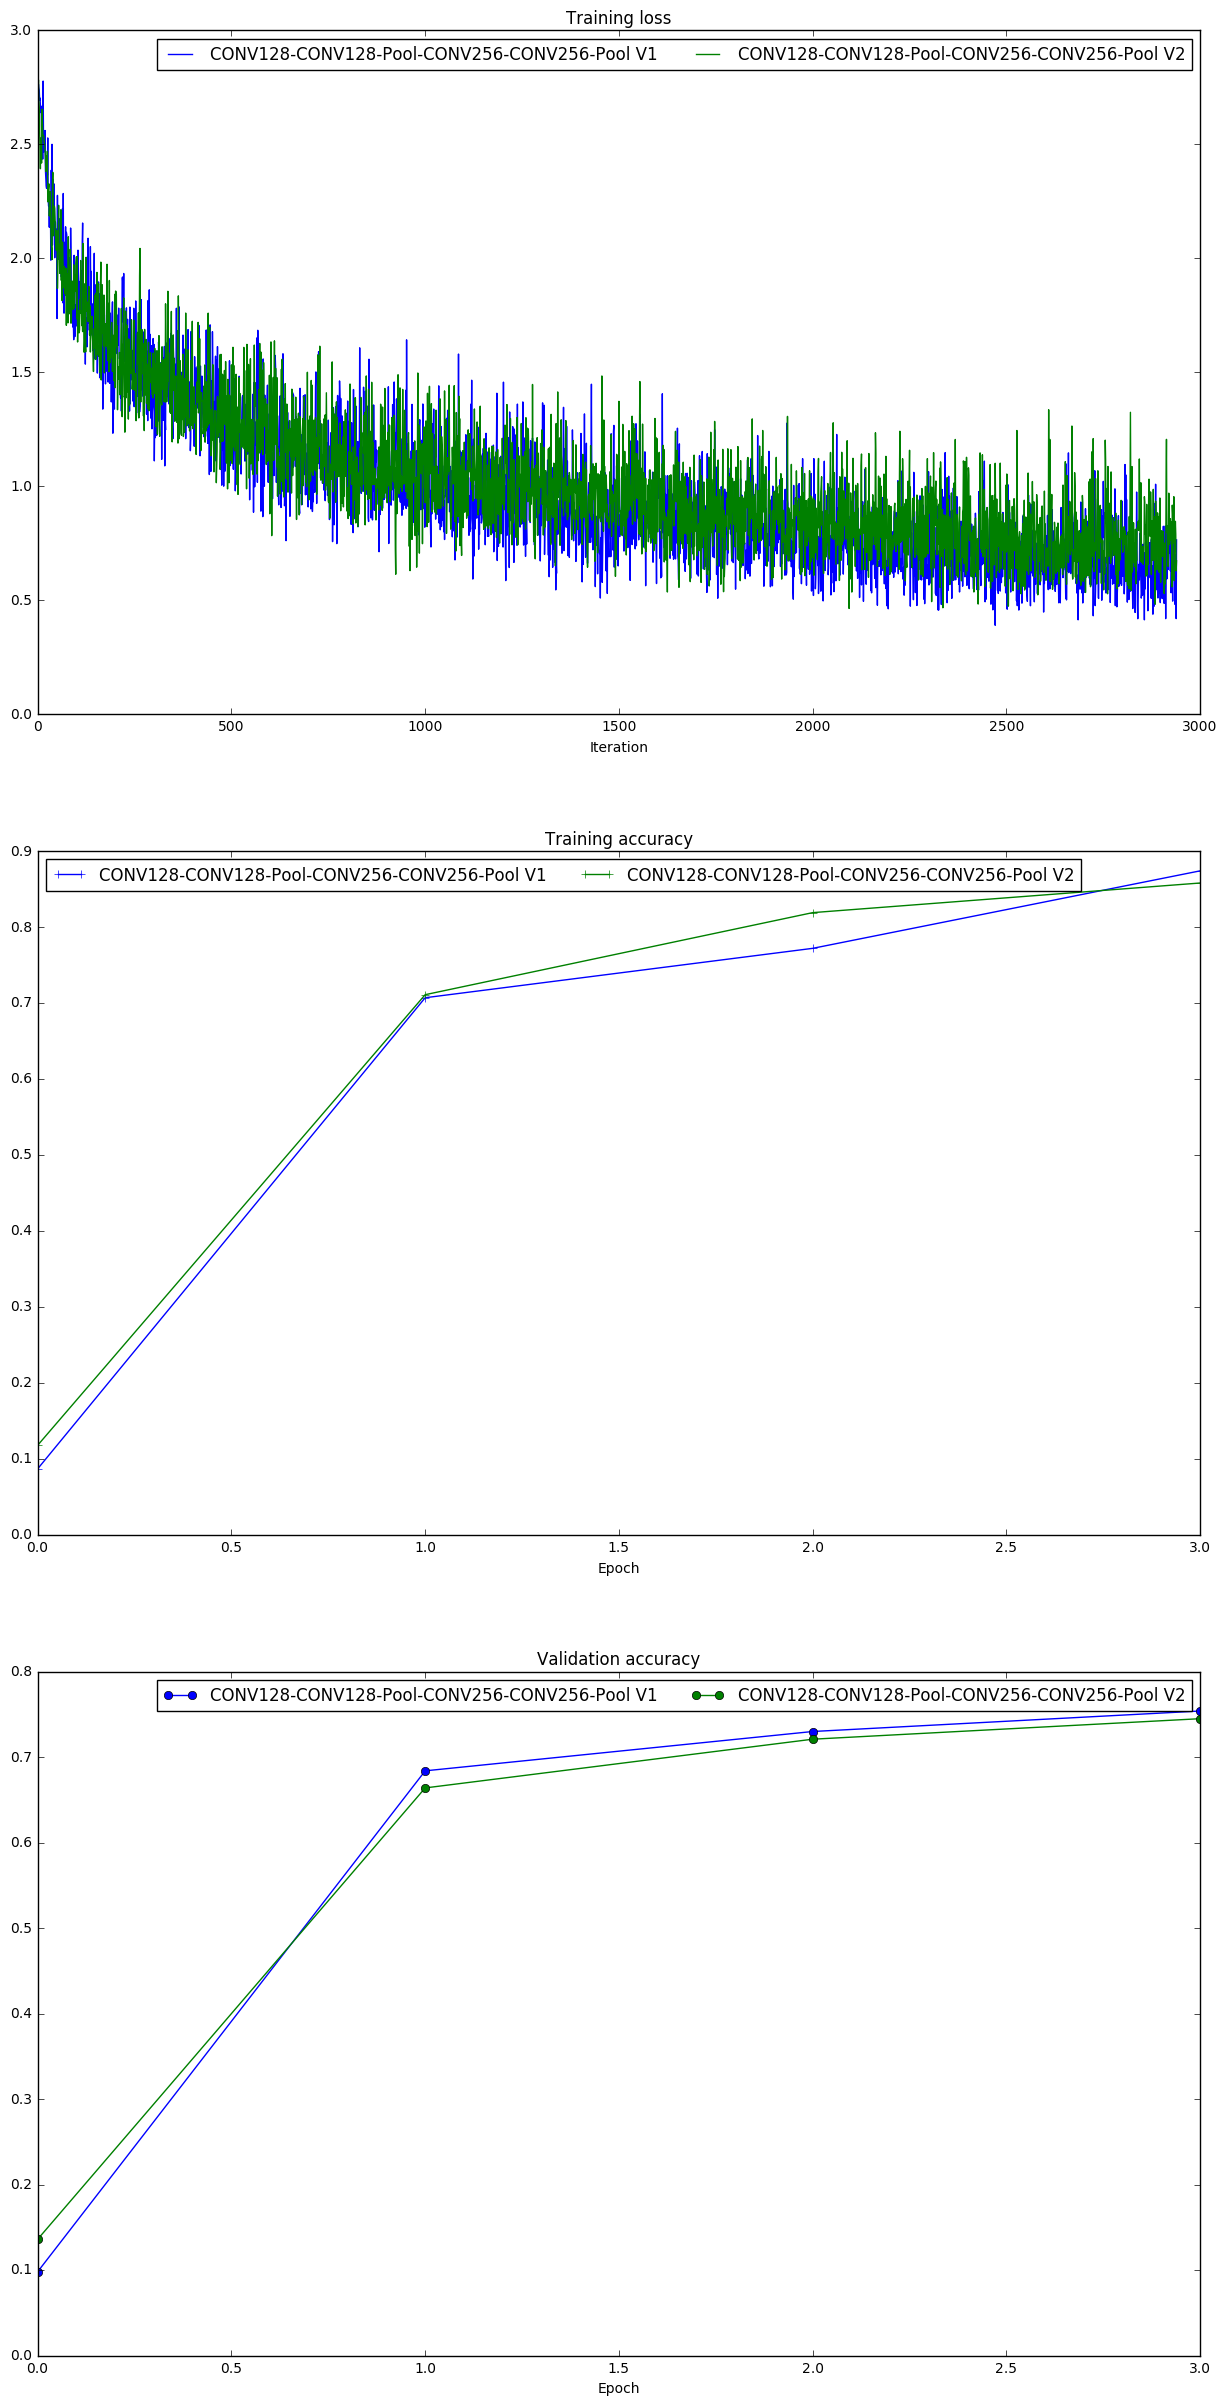

In [5]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

## DeepCNN2 Performance

Since vanishing gradient and maxpool issues limit DeepCNN2 to 2 blocks and 2 layers per block, we focus on this architecture and trained it to 3 epochs:

  'CONV128-CONV128-Pool-CONV256-CONV256-Pool':([[128,128],[256,256]],[[3,3],[3,3]])  

* Test accuracy flattens at 75%  
* Training and testing are pretty slow  

When we deepens the architecture to:

  '{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])  

After 5 epochs of training, validation accuracy remains stuck at 76.5% even as training accuracy --> 93%:  
(Epoch 5 / 5) train acc: 0.929000; val_acc: 0.765000  

We need to incorporate new techniques to solve the overfitting and vanishing gradient problems - e.g. batch normalization, Xavier initialization and dropoff.

In [6]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

Validation set accuracy:  0.754
Test set accuracy:  0.75


In [6]:
best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])
                        }
learning_rates = [2e-4]
regularization_strengths = [0.001]

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet2(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, xavier=True)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=5, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    }, lr_decay=0.95, verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: {CONV064}x2-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 2.000000e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 4900) loss: 5.656090
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.102000
(Iteration 21 / 4900) loss: 3.154286
(Iteration 41 / 4900) loss: 2.812181
(Iteration 61 / 4900) loss: 2.690910
(Iteration 81 / 4900) loss: 2.481403
(Iteration 101 / 4900) loss: 2.437306
(Iteration 121 / 4900) loss: 2.442821
(Iteration 141 / 4900) loss: 2.441808
(Iteration 161 / 4900) loss: 2.355138
(Iteration 181 / 4900) loss: 2.356699
(Iteration 201 / 4900) loss: 2.184199
(Iteration 221 / 4900) loss: 2.487927
(Iteration 241 / 4900) loss: 2.122271
(Iteration 261 / 4900) loss: 2.091326
(Iteration 281 / 4900) loss: 2.124112
(Iteration 301 / 4900) loss: 2.244702
(Iteration 321 / 4900) loss: 1.962449
(Iteration 341 / 4900) loss: 2.450677
(Iteration 361 / 4900) loss: 2.106540
(Iteration 381 / 4900) loss: 2.013147
(Iteration 401 / 4900) loss: 2.167951
(Iteration 421 / 4900) loss: 2.12780

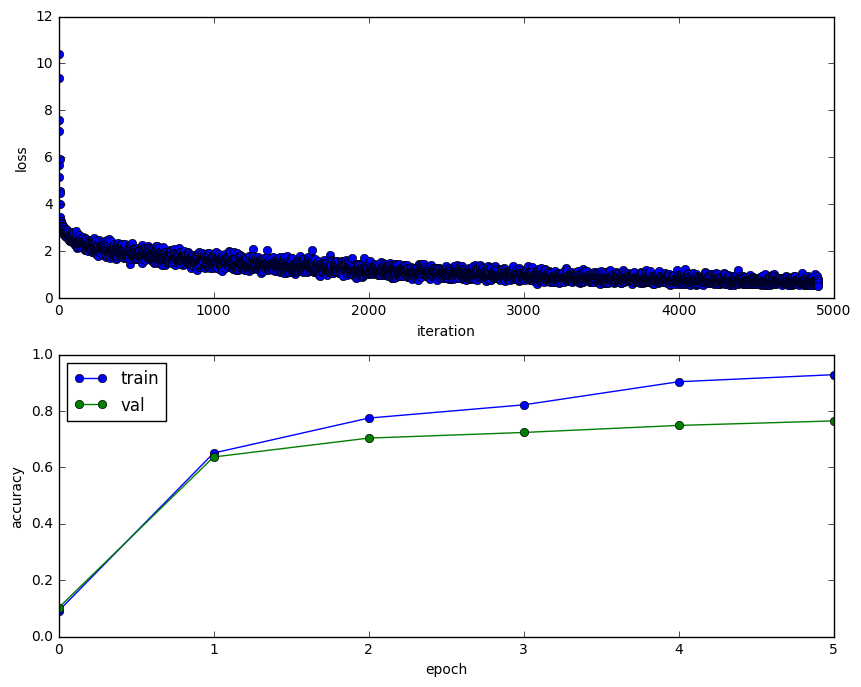

In [7]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## DeepCNN2 + Xavier - Overfitting Problem Remains

Our main conclusion from experiments conducted on DeepCNN2:

'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])  
Validation set accuracy:  0.765  
Test set accuracy:  0.755  

'{CONV032}x3-Pool-{CONV064}x3-Pool':([[32,32,32],[64,64,64]],[[3,3,3],[3,3,3]])  
Validation set accuracy:  0.775  
Test set accuracy:  0.751  

** Xavier Initialization allows deeper CNN to train, but it does not address the overfitting issue (validation accuracy remains stuck around 77%). **


In [8]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

Validation set accuracy:  0.765
Test set accuracy:  0.755


In [3]:
best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])
                        }
learning_rates = [2e-4]
regularization_strengths = [0.005, 0.001]

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet2(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, xavier=True)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=3, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    }, lr_decay=0.95, verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: {CONV064}x2-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 2.000000e-04 Reg Strength: 5.000000e-03 
(Iteration 1 / 2940) loss: 9.511839
(Epoch 0 / 3) train acc: 0.116000; val_acc: 0.105000
(Iteration 21 / 2940) loss: 6.289995
(Iteration 41 / 2940) loss: 5.749714
(Iteration 61 / 2940) loss: 5.394371
(Iteration 81 / 2940) loss: 5.301164
(Iteration 101 / 2940) loss: 5.164678
(Iteration 121 / 2940) loss: 5.304961
(Iteration 141 / 2940) loss: 4.864088
(Iteration 161 / 2940) loss: 4.954284
(Iteration 181 / 2940) loss: 4.708621
(Iteration 201 / 2940) loss: 4.733174
(Iteration 221 / 2940) loss: 4.519270
(Iteration 241 / 2940) loss: 4.390970
(Iteration 261 / 2940) loss: 4.459722
(Iteration 281 / 2940) loss: 4.214776
(Iteration 301 / 2940) loss: 4.092394
(Iteration 321 / 2940) loss: 4.402710
(Iteration 341 / 2940) loss: 4.201596
(Iteration 361 / 2940) loss: 4.163633
(Iteration 381 / 2940) loss: 3.817764
(Iteration 401 / 2940) loss: 3.936258
(Iteration 421 / 2940) loss: 3.83540

{CONV064}x2-Pool-{CONV128}x3-Pool (Version 1) lr = 2.000000e-04; reg = 5.000000e-03, val accuracy: 0.709000
{CONV064}x2-Pool-{CONV128}x3-Pool (Version 2) lr = 2.000000e-04; reg = 1.000000e-03, val accuracy: 0.721000
best validation accuracy achieved during cross-validation: 0.721000



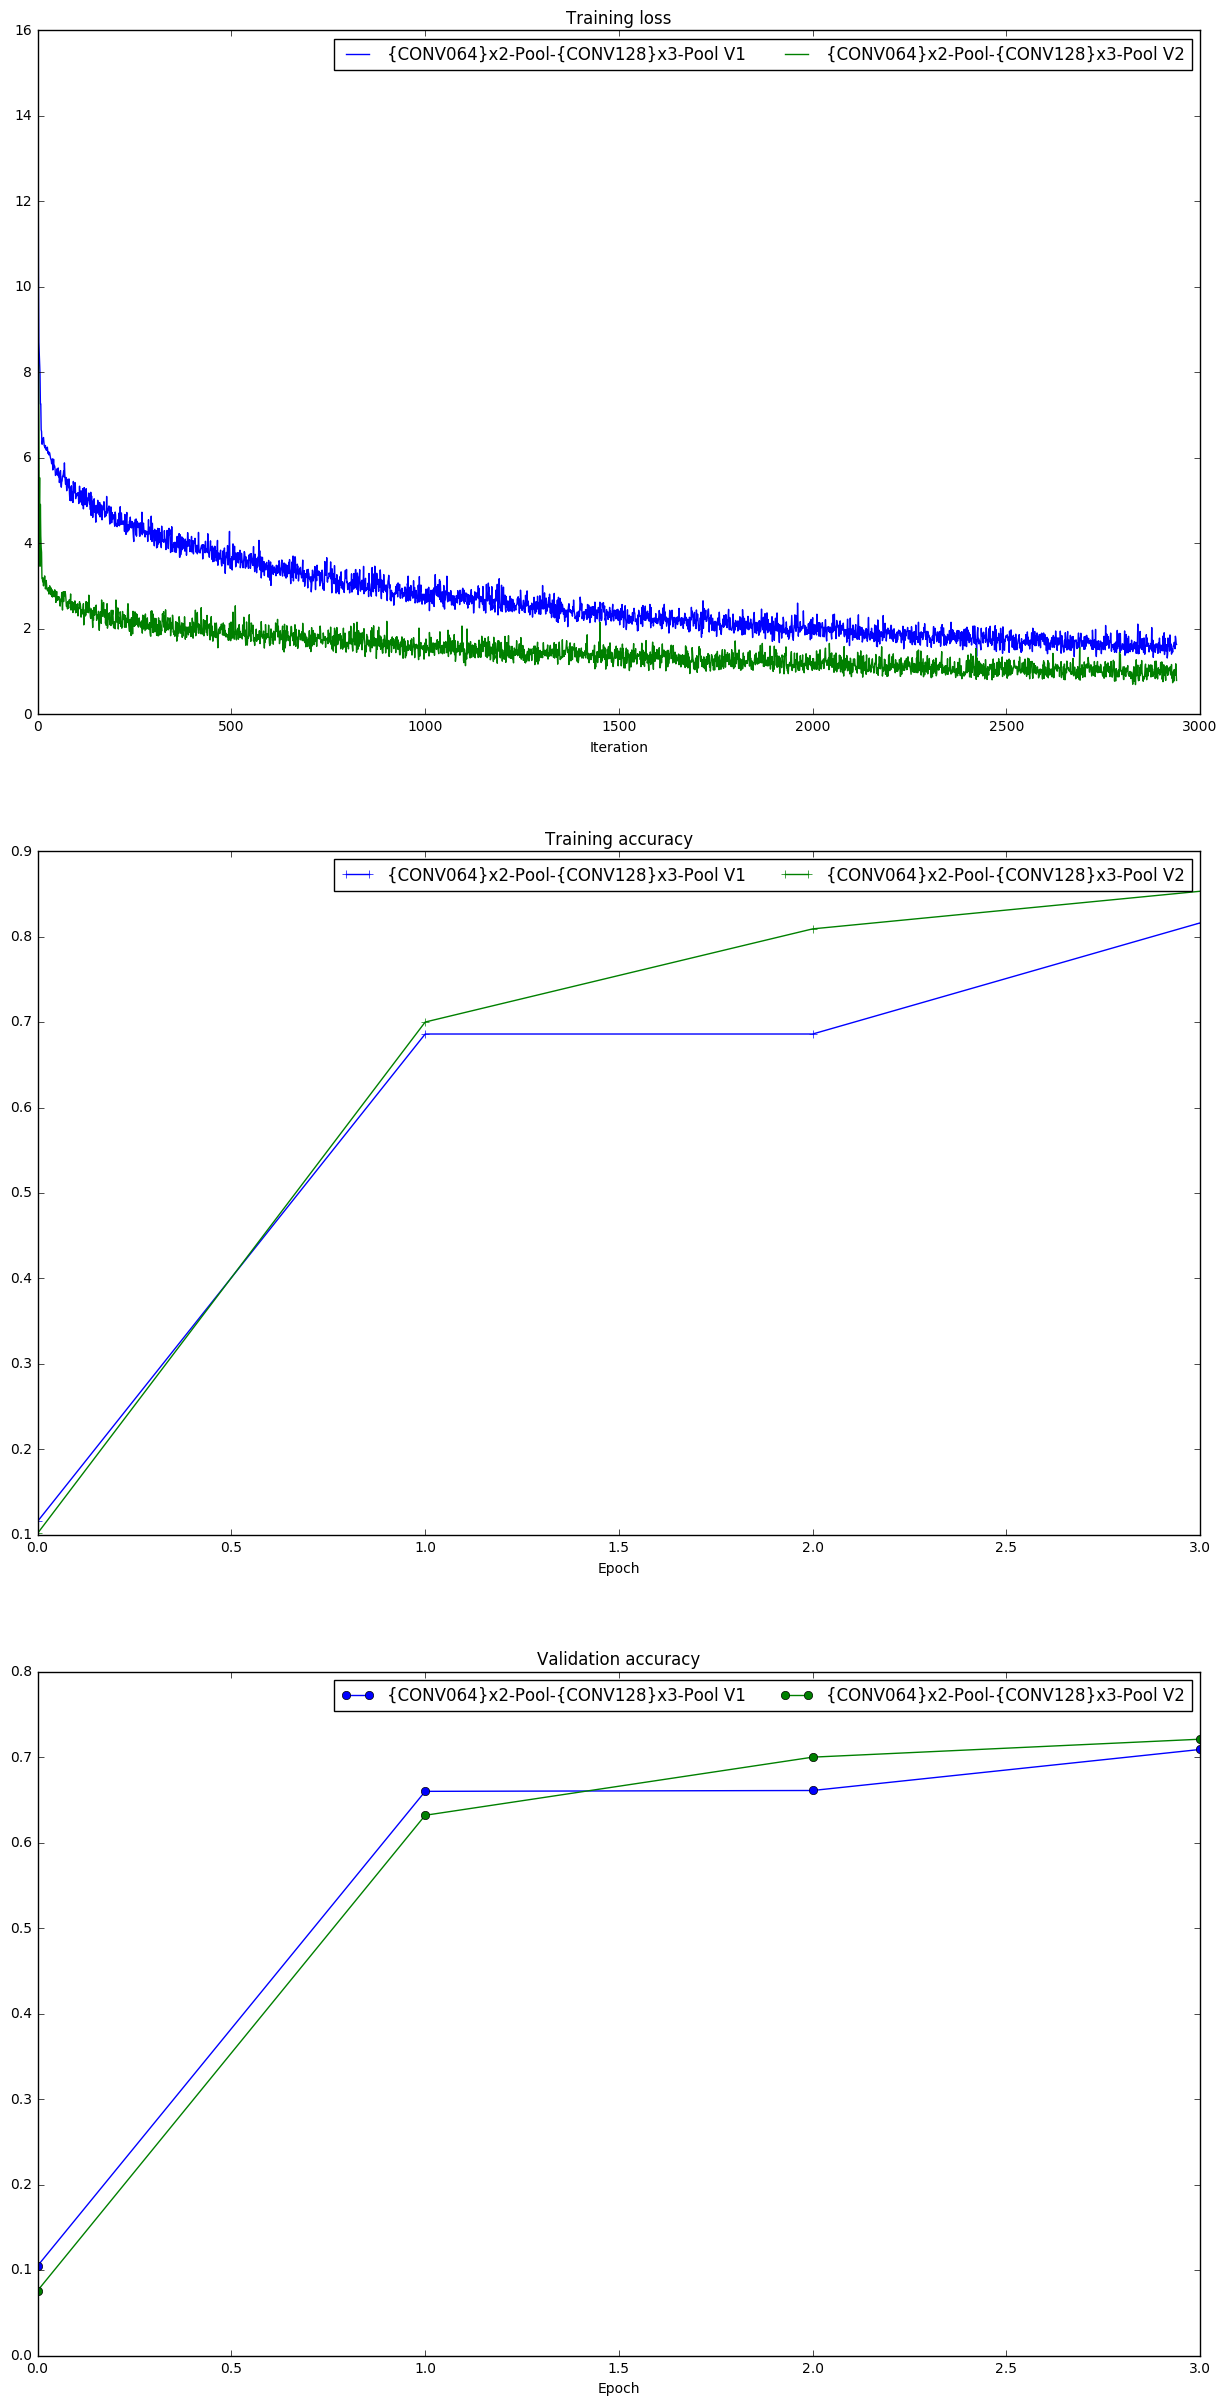

In [4]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

In [4]:
best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV032}x3-Pool-{CONV064}x3-Pool':([[32,32,32],[64,64,64]],[[3,3,3],[3,3,3]])
                        }

parameters = {(2e-04, 5e-04),(4e-4,0.001),(4e-4,0.005)}

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr,reg in parameters:
            print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
            num_filters, filter_sizes = network
            model = DeepConvNet2(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, xavier=True)

            t1 = time()               
            solver = Solver(model, data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
            },verbose=True, print_every=20)
            solvers[(label,i,version,lr,reg)] = solver
            solver.train()
            t2 = time()

            times[(label,i,version,lr,reg)] = (t2 - t1)
            print 'Training Time: %fs' % (t2 - t1)
        
            results[(label,i,version,lr,reg)] = solver.best_val_acc
  
            if (solver.best_val_acc > best_val):
                best_val = solver.best_val_acc
                best_model = model
            
            version += 1

CONV Network: {CONV032}x3-Pool-{CONV064}x3-Pool
Run number: 0 
Learning rate: 4.000000e-04 Reg Strength: 5.000000e-03 
(Iteration 1 / 9800) loss: 11.816940
(Epoch 0 / 10) train acc: 0.119000; val_acc: 0.120000
(Iteration 21 / 9800) loss: 5.450635
(Iteration 41 / 9800) loss: 5.066327
(Iteration 61 / 9800) loss: 4.837688
(Iteration 81 / 9800) loss: 4.705861
(Iteration 101 / 9800) loss: 4.313178
(Iteration 121 / 9800) loss: 4.171212
(Iteration 141 / 9800) loss: 4.186997
(Iteration 161 / 9800) loss: 4.421195
(Iteration 181 / 9800) loss: 3.877011
(Iteration 201 / 9800) loss: 3.796498
(Iteration 221 / 9800) loss: 3.893750
(Iteration 241 / 9800) loss: 3.853203
(Iteration 261 / 9800) loss: 3.728550
(Iteration 281 / 9800) loss: 3.800301
(Iteration 301 / 9800) loss: 3.698115
(Iteration 321 / 9800) loss: 3.283960
(Iteration 341 / 9800) loss: 3.523756
(Iteration 361 / 9800) loss: 3.464785
(Iteration 381 / 9800) loss: 3.194113
(Iteration 401 / 9800) loss: 3.256632
(Iteration 421 / 9800) loss: 3.137

{CONV032}x3-Pool-{CONV064}x3-Pool (Version 1) lr = 4.000000e-04; reg = 5.000000e-03, val accuracy: 0.775000
{CONV032}x3-Pool-{CONV064}x3-Pool (Version 2) lr = 4.000000e-04; reg = 1.000000e-03, val accuracy: 0.749000
{CONV032}x3-Pool-{CONV064}x3-Pool (Version 3) lr = 2.000000e-04; reg = 5.000000e-04, val accuracy: 0.724000
best validation accuracy achieved during cross-validation: 0.775000



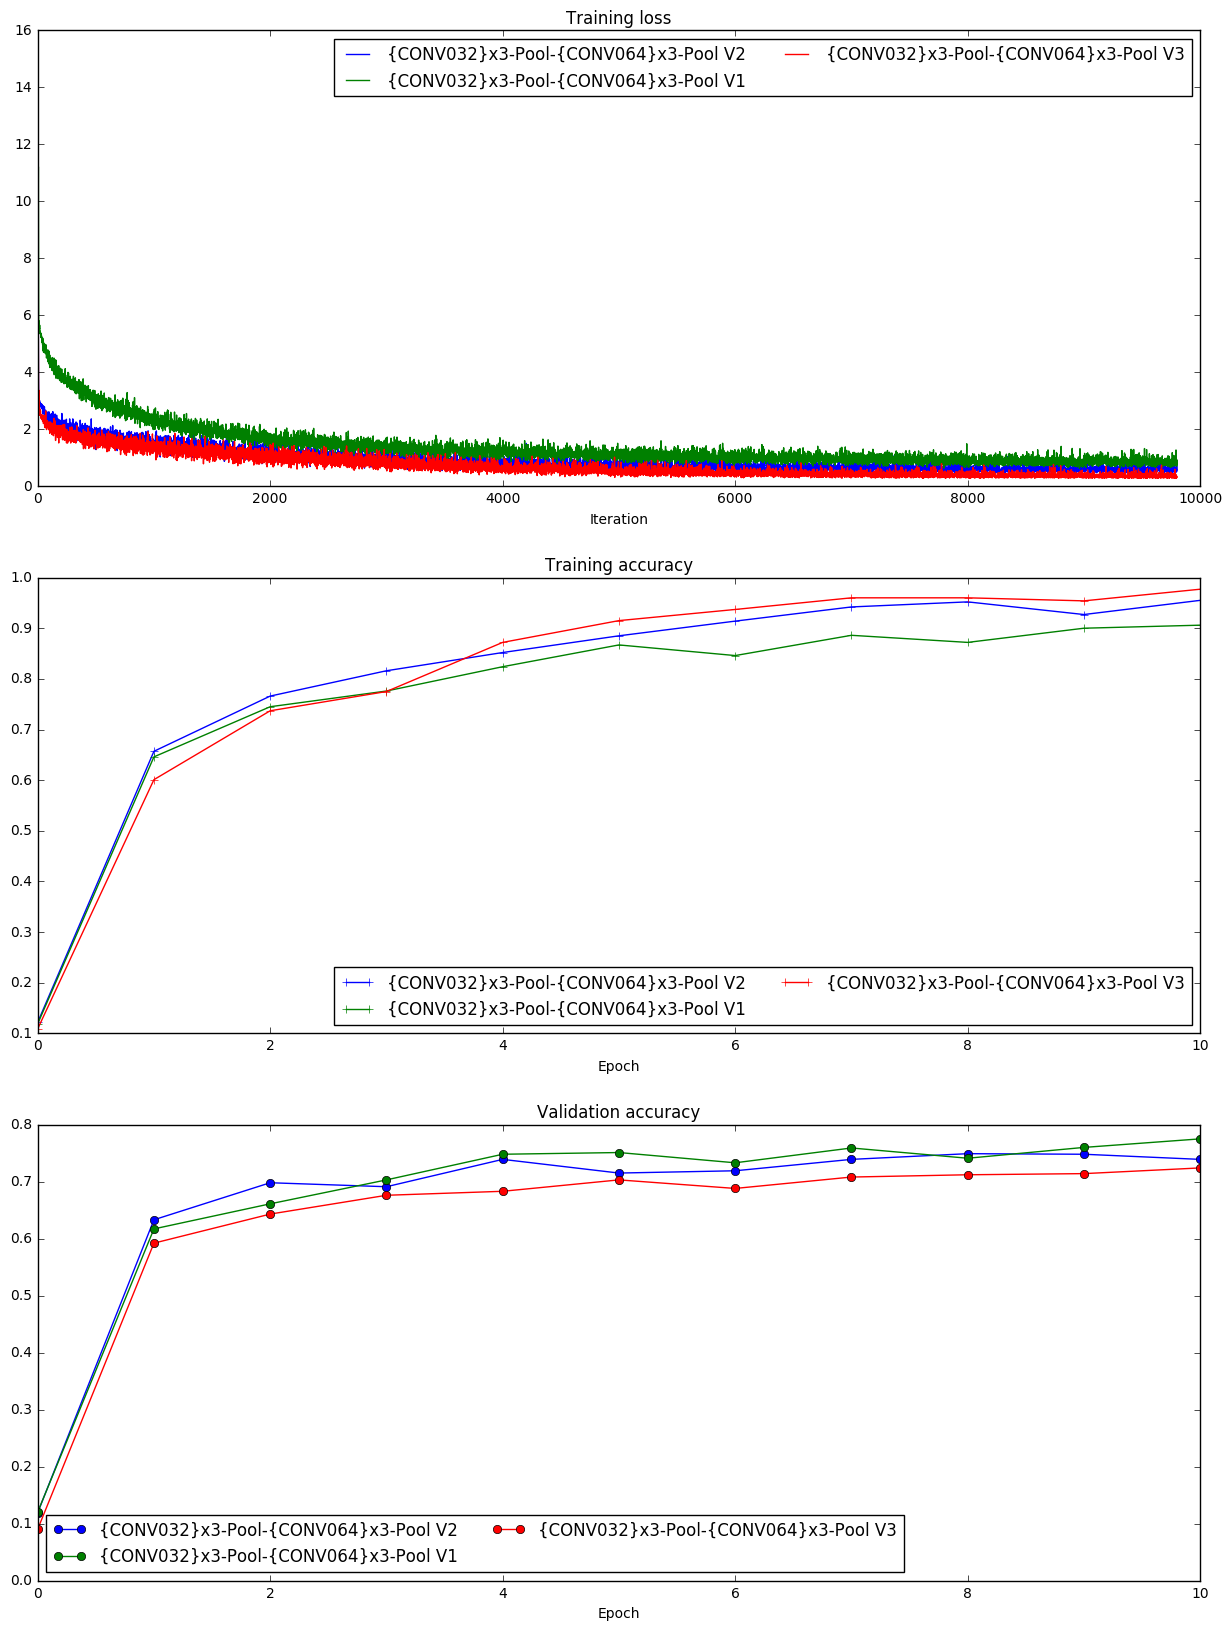

In [6]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 20)
plt.show()

In [7]:
t1 = time()
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.775
Test set accuracy:  0.751
Testing Time: 13.469000s


In [11]:
from cs231n.classifiers.convnet3 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x3-Pool-{CONV128}x3-Pool':([[64,64,64],[128,128,128]],[[3,3,3],[3,3,3]])
                        }

parameters = {(4e-4,0.005)}

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr,reg in parameters:
            print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
            num_filters, filter_sizes = network
            model = DeepConvNet3(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, use_batchnorm=True)

            t1 = time()               
            solver = Solver(model, data,
                    num_epochs=5, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
            }, lr_decay=0.95, verbose=True, print_every=20)
            solvers[(label,i,version,lr,reg)] = solver
            solver.train()
            t2 = time()

            times[(label,i,version,lr,reg)] = (t2 - t1)
            print 'Training Time: %fs' % (t2 - t1)
        
            results[(label,i,version,lr,reg)] = solver.best_val_acc
  
            if (solver.best_val_acc > best_val):
                best_val = solver.best_val_acc
                best_model = model
            
            version += 1

CONV Network: {CONV064}x3-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 4.000000e-04 Reg Strength: 5.000000e-03 
(Iteration 1 / 4900) loss: 3.404474
(Epoch 0 / 5) train acc: 0.096000; val_acc: 0.111000
(Iteration 21 / 4900) loss: 2.919518
(Iteration 41 / 4900) loss: 2.706245
(Iteration 61 / 4900) loss: 2.677974
(Iteration 81 / 4900) loss: 2.262172
(Iteration 101 / 4900) loss: 1.961982
(Iteration 121 / 4900) loss: 1.921695
(Iteration 141 / 4900) loss: 1.733123
(Iteration 161 / 4900) loss: 1.662370
(Iteration 181 / 4900) loss: 1.721271
(Iteration 201 / 4900) loss: 1.633100
(Iteration 221 / 4900) loss: 1.445530
(Iteration 241 / 4900) loss: 1.410044
(Iteration 261 / 4900) loss: 1.463779
(Iteration 281 / 4900) loss: 1.292687
(Iteration 301 / 4900) loss: 1.543998
(Iteration 321 / 4900) loss: 1.362000
(Iteration 341 / 4900) loss: 1.461376
(Iteration 361 / 4900) loss: 1.477488
(Iteration 381 / 4900) loss: 1.579177
(Iteration 401 / 4900) loss: 1.142390
(Iteration 421 / 4900) loss: 1.33203

In [5]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

ValueError: need more than 2 values to unpack

In [3]:
from cs231n.classifiers.convnet3 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])
                        }
learning_rates = [1e-2,1e-3,1e-4]
regularization_strengths = [0.0001, 0.001, 0.01]

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet3(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, use_batchnorm=True)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=1, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    }, lr_decay=0.95, verbose=True, print_every=50)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: {CONV064}x2-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 2.000000e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 9800) loss: 2.514845
(Epoch 0 / 10) train acc: 0.115000; val_acc: 0.123000
(Iteration 21 / 9800) loss: 2.123646
(Iteration 41 / 9800) loss: 2.047423
(Iteration 61 / 9800) loss: 1.732010
(Iteration 81 / 9800) loss: 1.713295
(Iteration 101 / 9800) loss: 1.520312
(Iteration 121 / 9800) loss: 1.623963
(Iteration 141 / 9800) loss: 1.388440
(Iteration 161 / 9800) loss: 1.496385
(Iteration 181 / 9800) loss: 1.265874
(Iteration 201 / 9800) loss: 1.363958
(Iteration 221 / 9800) loss: 1.351614
(Iteration 241 / 9800) loss: 1.330483
(Iteration 261 / 9800) loss: 1.193634
(Iteration 281 / 9800) loss: 1.362840
(Iteration 301 / 9800) loss: 1.235595
(Iteration 321 / 9800) loss: 1.100670
(Iteration 341 / 9800) loss: 1.184539
(Iteration 361 / 9800) loss: 1.143586
(Iteration 381 / 9800) loss: 0.970807
(Iteration 401 / 9800) loss: 1.080035
(Iteration 421 / 9800) loss: 1.0192

{CONV064}x2-Pool-{CONV128}x3-Pool (Version 1) lr = 2.000000e-04; reg = 1.000000e-03, val accuracy: 0.854000
best validation accuracy achieved during cross-validation: 0.854000



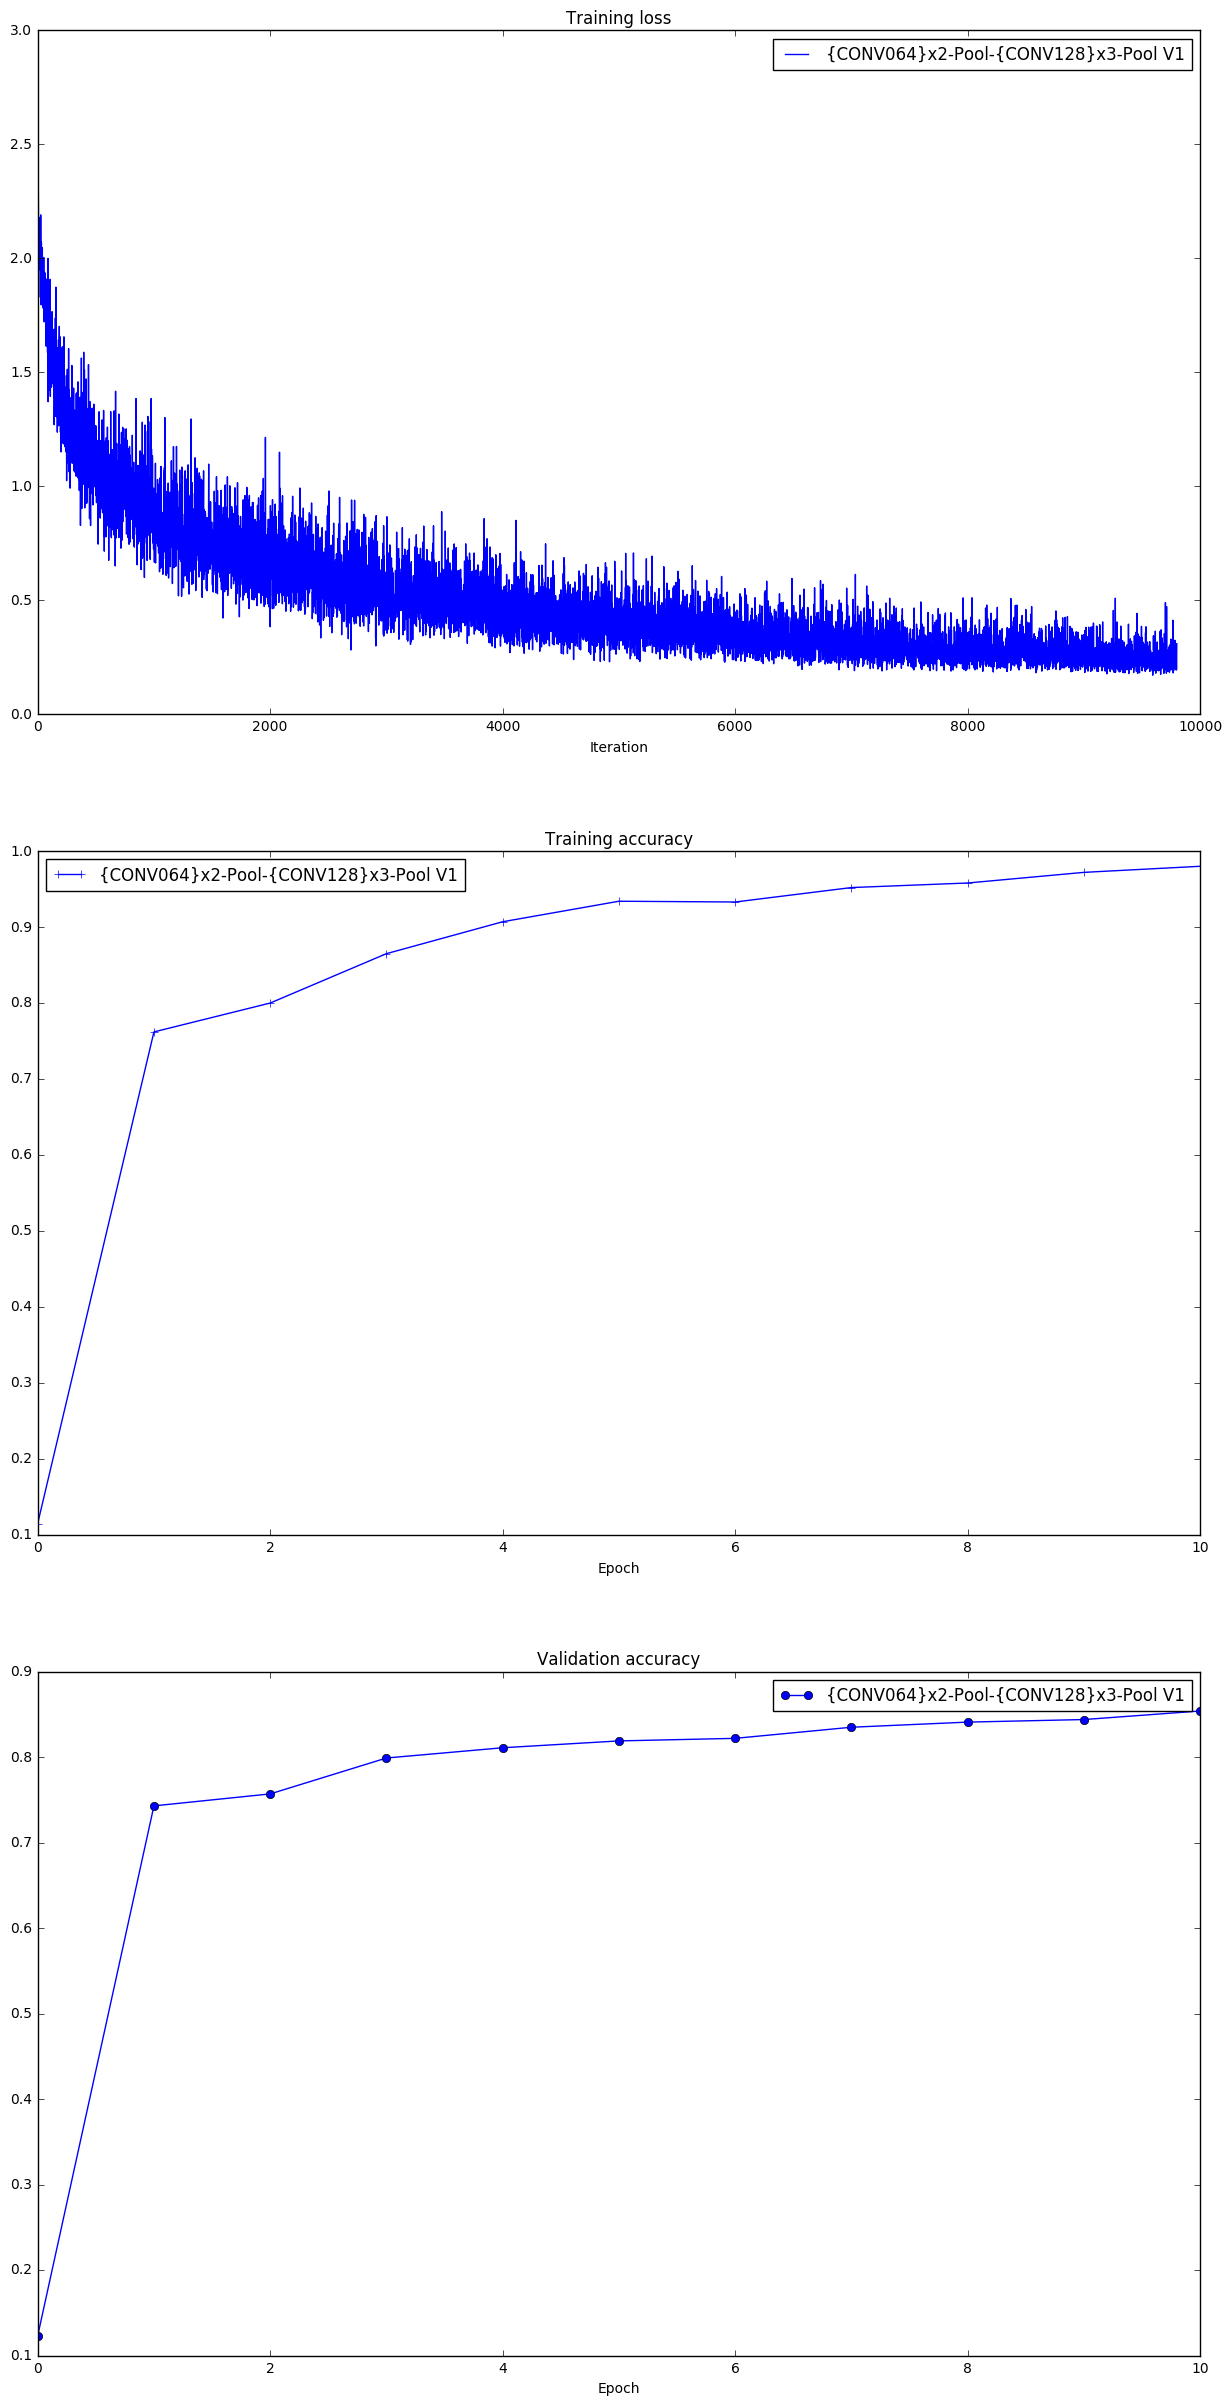

In [4]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

In [17]:
t1 = time()
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.854
Test set accuracy:  0.826
Testing Time: 22.560000s


In [4]:
from cs231n.classifiers.convnet3 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

parameters = {(2e-3, 0),(2e-03, 1e-4),(2e-03, 1e-3)}
for lr, reg in parameters:

        model = DeepConvNet3(num_filters=[[32,64,64],[128,128,128]], filter_sizes=[[3,3,3],[3,3,3]], 
                             hidden_dim=500, weight_scale=1e-2, reg = reg, use_batchnorm=True)

        solver = Solver(model, data,
                num_epochs=5, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': lr,
                }, lr_decay=0.95,
                verbose=True, print_every=50)

        solver.train()
        solvers[(lr,reg)] = solver
        results[(lr,reg)] = solver.best_val_acc
        if (solver.best_val_acc > best_val):
            best_val = solver.best_val_acc
            best_model = model

(Iteration 1 / 2450) loss: 2.322969
(Epoch 0 / 5) train acc: 0.122000; val_acc: 0.111000
(Iteration 51 / 2450) loss: 1.718258
(Iteration 101 / 2450) loss: 1.262944
(Iteration 151 / 2450) loss: 1.115829
(Iteration 201 / 2450) loss: 1.252480
(Iteration 251 / 2450) loss: 1.031170
(Iteration 301 / 2450) loss: 0.908692
(Iteration 351 / 2450) loss: 0.896377
(Iteration 401 / 2450) loss: 0.821619
(Iteration 451 / 2450) loss: 0.795598
(Epoch 1 / 5) train acc: 0.659000; val_acc: 0.646000
(Iteration 501 / 2450) loss: 0.917770
(Iteration 551 / 2450) loss: 0.584873
(Iteration 601 / 2450) loss: 0.743384
(Iteration 651 / 2450) loss: 0.629231
(Iteration 701 / 2450) loss: 0.607039
(Iteration 751 / 2450) loss: 0.439970
(Iteration 801 / 2450) loss: 0.771943
(Iteration 851 / 2450) loss: 0.528869
(Iteration 901 / 2450) loss: 0.531457
(Iteration 951 / 2450) loss: 0.588094
(Epoch 2 / 5) train acc: 0.775000; val_acc: 0.717000
(Iteration 1001 / 2450) loss: 0.472167
(Iteration 1051 / 2450) loss: 0.388235
(Itera

lr = 2.000000e-03; reg = 0.000000e+00, val accuracy: 0.815000
lr = 2.000000e-03; reg = 1.000000e-04, val accuracy: 0.802000
lr = 2.000000e-03; reg = 1.000000e-03, val accuracy: 0.690000
best validation accuracy achieved during cross-validation: 0.815000



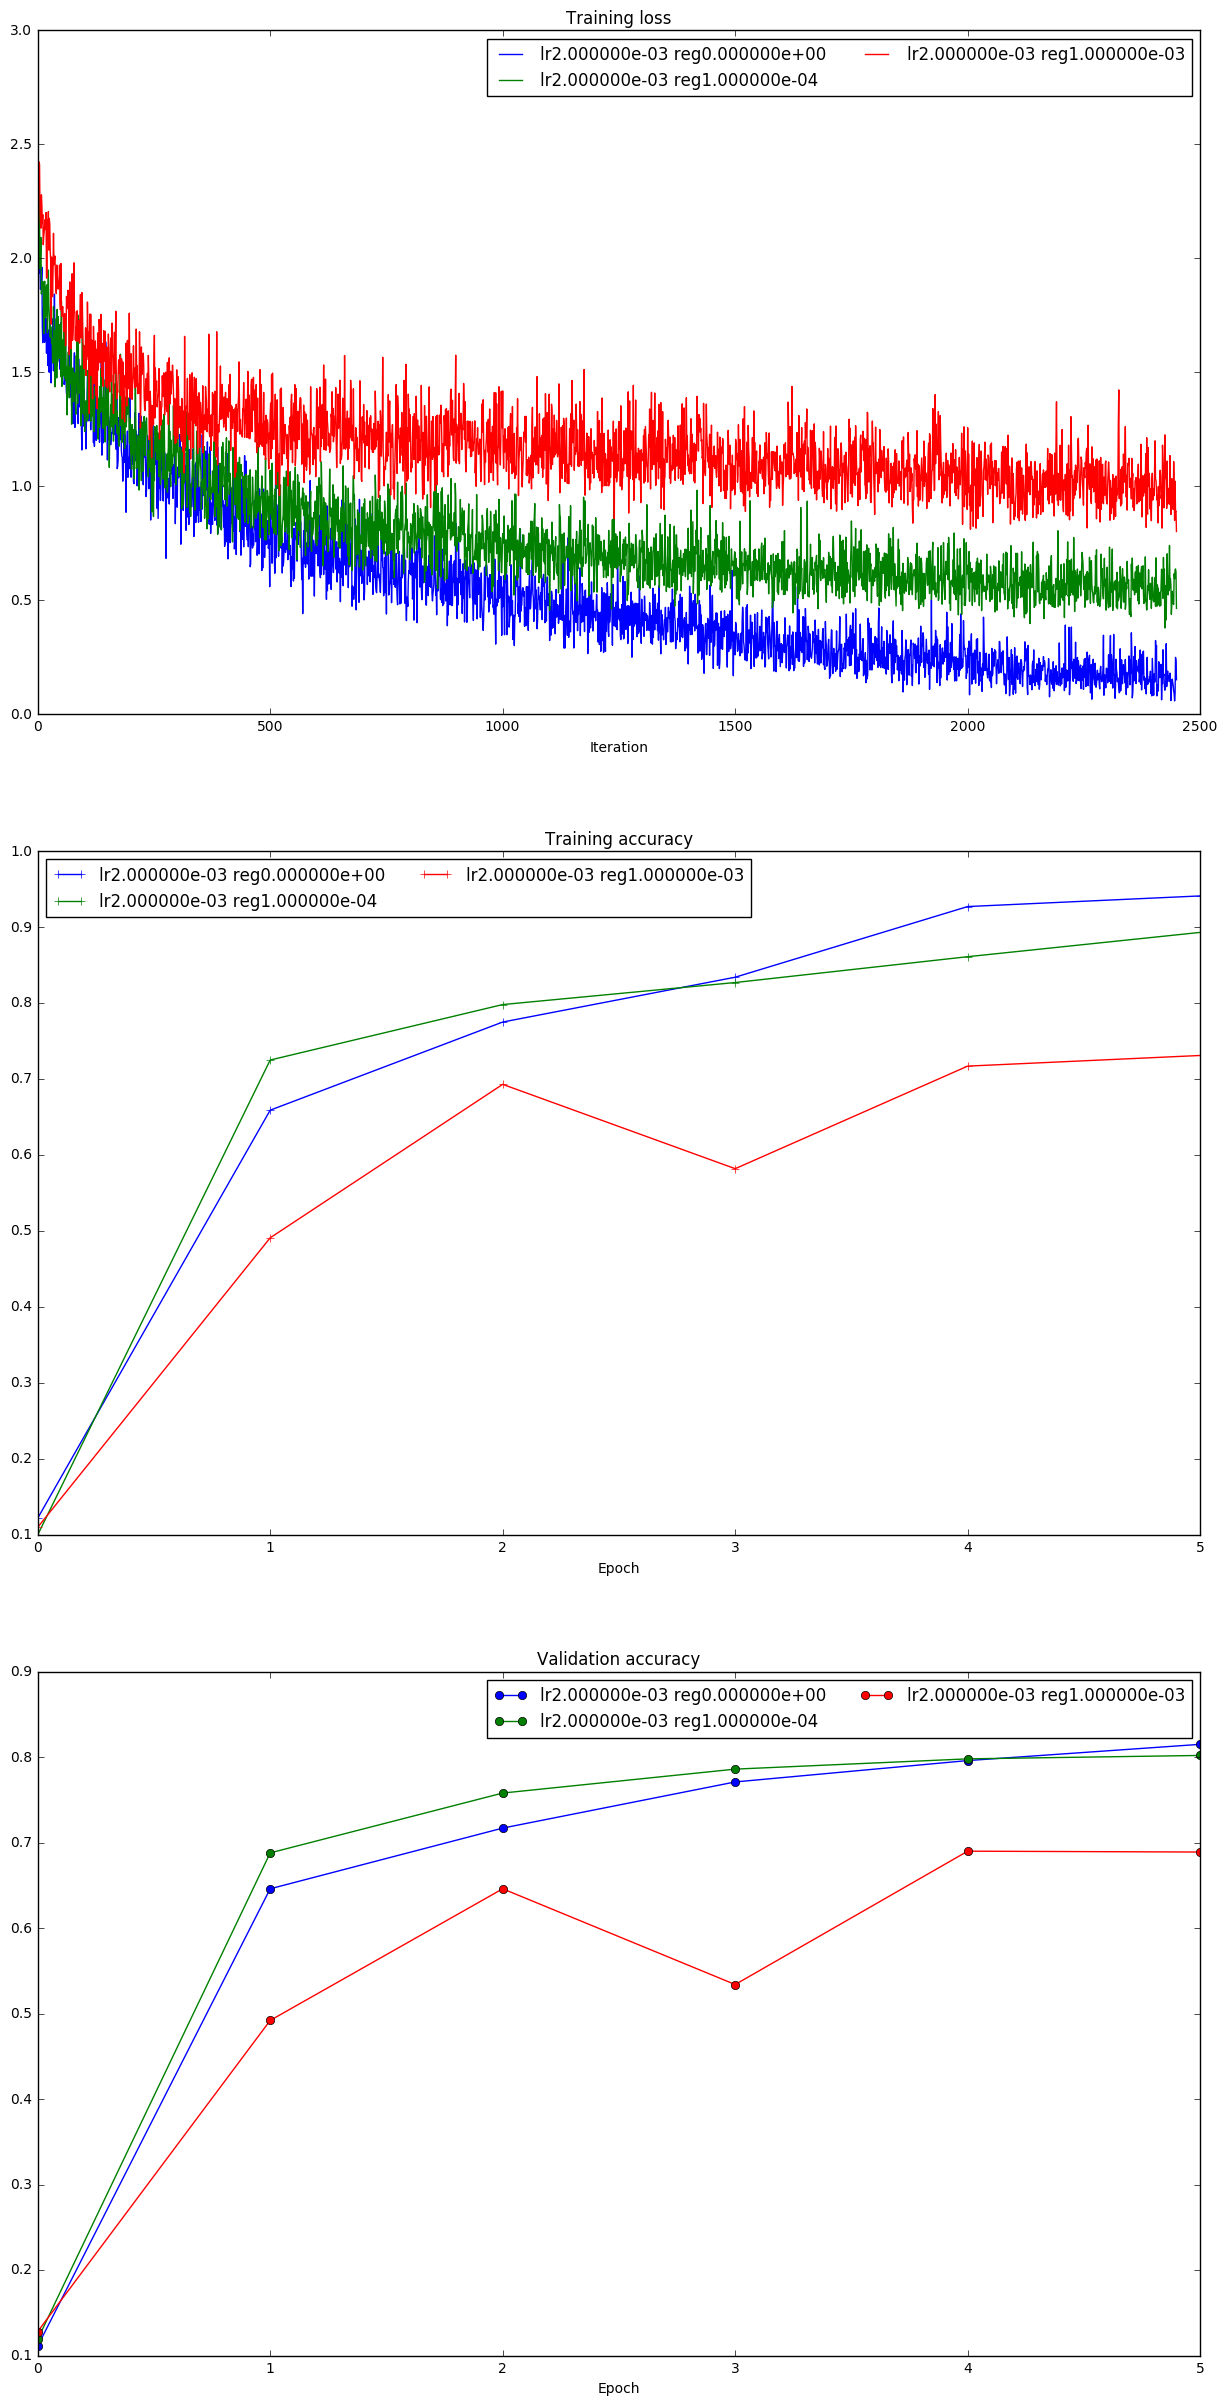

In [6]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    lr, reg = param
    print 'lr = %e; reg = %e, val accuracy: %f' % (lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "lr%e reg%e" % (items[0], items[1])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

In [7]:
t1 = time()
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.815
Test set accuracy:  0.806
Testing Time: 47.706000s


In [6]:
outfile = 'bestparams-2.npz'

np.savez(outfile, **{'params': model.params, 'bn_params': model.bn_params})

npzfile = np.load(outfile)

npzfile.files

['bn_params', 'params']

In [7]:
outfile = 'bestparams-2.npz'
npzfile = np.load(outfile)

params = npzfile['params'].item()
bn_params = npzfile['bn_params'].item()

# This was the model that was trained

model = DeepConvNet3(num_filters=[[32,64,64],[128,128,128]], filter_sizes=[[3,3,3],[3,3,3]], weight_scale=1e-2, 
                    hidden_dim=500, verbose=False, reg = 0, use_batchnorm=True)

model.params = params  # Transfer parameters from pre-trained model
model.bn_params = bn_params  # Transfer parameters from pre-trained model

t1 = time()
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.843
Test set accuracy:  0.837
Testing Time: 24.355000s


Successfully saved and loaded a trained model!!

In [24]:
t1 = time()
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.809
Test set accuracy:  0.8
Testing Time: 22.703000s


In [3]:
from cs231n.classifiers.convnet3 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

parameters = {(1e-3, 0),(1e-03, 1e-4),(1e-03, 1e-3)}
for lr, reg in parameters:

        model = DeepConvNet3(num_filters=[[64,64],[128,128,128]], filter_sizes=[[3,3],[3,3,3]], 
                             hidden_dim=500, weight_scale=1e-2, reg = reg, use_batchnorm=True)

        solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': lr,
                }, lr_decay=0.95,
                verbose=True, print_every=50)

        solver.train_bn()  # new train_bn() for saving best model 
        solvers[(lr,reg)] = solver
        results[(lr,reg)] = solver.best_val_acc
        if (solver.best_val_acc > best_val):
            best_val = solver.best_val_acc
            best_model = model

(Iteration 1 / 4900) loss: 2.322292
(Epoch 0 / 10) train acc: 0.152000; val_acc: 0.145000
(Iteration 51 / 4900) loss: 1.703706
(Iteration 101 / 4900) loss: 1.201900
(Iteration 151 / 4900) loss: 1.055432
(Iteration 201 / 4900) loss: 1.137911
(Iteration 251 / 4900) loss: 1.046081
(Iteration 301 / 4900) loss: 0.879006
(Iteration 351 / 4900) loss: 0.861162
(Iteration 401 / 4900) loss: 0.975821
(Iteration 451 / 4900) loss: 0.852214
(Epoch 1 / 10) train acc: 0.638000; val_acc: 0.654000
(Iteration 501 / 4900) loss: 0.616456
(Iteration 551 / 4900) loss: 0.647136
(Iteration 601 / 4900) loss: 0.613151
(Iteration 651 / 4900) loss: 0.697499
(Iteration 701 / 4900) loss: 0.540556
(Iteration 751 / 4900) loss: 0.781665
(Iteration 801 / 4900) loss: 0.683804
(Iteration 851 / 4900) loss: 0.661802
(Iteration 901 / 4900) loss: 0.821493
(Iteration 951 / 4900) loss: 0.566963
(Epoch 2 / 10) train acc: 0.828000; val_acc: 0.772000
(Iteration 1001 / 4900) loss: 0.537874
(Iteration 1051 / 4900) loss: 0.617173
(It

In [4]:
t1 = time()
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.849
Test set accuracy:  0.85
Testing Time: 21.365000s


In [10]:
outfile = 'bestparams-4.npz'

np.savez(outfile, **{'params': best_model.params, 'bn_params': best_model.bn_params})

npzfile = np.load(outfile)

npzfile.files

['bn_params', 'params']

In [6]:
t1 = time()
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.84
Test set accuracy:  0.823
Testing Time: 18.430000s


In [7]:
outfile = 'bestparams-5.npz'

np.savez(outfile, **{'params': model.params, 'bn_params': model.bn_params})

npzfile = np.load(outfile)

npzfile.files

['bn_params', 'params']

In [11]:
# Load pre-trained model that achieved 83% validation accuracy
outfile = 'bestparams-5.npz'
npzfile = np.load(outfile)

params = npzfile['params'].item()
bn_params = npzfile['bn_params'].item()

# Train 10 more epochs


model = DeepConvNet3(num_filters=[[64,64],[128,128,128]], filter_sizes=[[3,3],[3,3,3]], 
                             hidden_dim=500, weight_scale=1e-2, reg = 1e-3, use_batchnorm=True)
model.params = params
model.bn_params = bn_params

solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-04,
                }, lr_decay=0.95,
                verbose=True, print_every=50)

solver.train()

(Iteration 1 / 4900) loss: 0.508190
(Epoch 0 / 10) train acc: 0.938000; val_acc: 0.836000
(Iteration 51 / 4900) loss: 0.499440
(Iteration 101 / 4900) loss: 0.563157
(Iteration 151 / 4900) loss: 0.451270
(Iteration 201 / 4900) loss: 0.600142
(Iteration 251 / 4900) loss: 0.492826
(Iteration 301 / 4900) loss: 0.553925
(Iteration 351 / 4900) loss: 0.471800
(Iteration 401 / 4900) loss: 0.432400
(Iteration 451 / 4900) loss: 0.455032
(Epoch 1 / 10) train acc: 0.946000; val_acc: 0.855000
(Iteration 501 / 4900) loss: 0.422010
(Iteration 551 / 4900) loss: 0.462893
(Iteration 601 / 4900) loss: 0.449288
(Iteration 651 / 4900) loss: 0.509131
(Iteration 701 / 4900) loss: 0.368554
(Iteration 751 / 4900) loss: 0.394167
(Iteration 801 / 4900) loss: 0.408314
(Iteration 851 / 4900) loss: 0.466812
(Iteration 901 / 4900) loss: 0.461297
(Iteration 951 / 4900) loss: 0.471707
(Epoch 2 / 10) train acc: 0.926000; val_acc: 0.850000
(Iteration 1001 / 4900) loss: 0.349258
(Iteration 1051 / 4900) loss: 0.392065
(It

In [12]:
outfile = 'bestparams-5.npz'

np.savez(outfile, **{'params': model.params, 'bn_params': model.bn_params})

npzfile = np.load(outfile)

npzfile.files

['bn_params', 'params']

In [13]:
t1 = time()
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
t2 = time()

y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

print 'Testing Time: %fs' % (t2 - t1)

Validation set accuracy:  0.859
Test set accuracy:  0.844
Testing Time: 20.922000s
